In [ ]:
!unzip Annotations.zip

In [ ]:
!unzip ImageSets.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import DetrForObjectDetection, DetrConfig
from PIL import Image
import xml.etree.ElementTree as ET

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger le modèle DOFA
dofa_model = torch.hub.load('zhu-xlab/DOFA', 'vit_base_dofa', pretrained=True).to(device)
# Désactiver la mise à jour des poids de DOFA pour l'utiliser comme extracteur de features figé
for param in dofa_model.parameters():
    param.requires_grad = False

class DOFAFeatureExtractor(nn.Module):
    def __init__(self, dofa_model):
        super().__init__()
        self.dofa = dofa_model

    def forward(self, pixel_values, wavelengths=None):
        patch_embed_output = self.dofa.patch_embed(pixel_values, wvs=wavelengths)
        # Si l'encodage retourne un tuple, on sélectionne le premier élément (les features)
        if isinstance(patch_embed_output, tuple):
            features = patch_embed_output[0]  
        else:
            features = patch_embed_output
        # Normalisation des features avec la couche fully-connected de normalisation du modèle DOFA
        features = self.dofa.fc_norm(features)

        # Passage des features à travers chaque bloc du modèle DOFA 
        for block in self.dofa.blocks:
            features = block(features)

        return features

feature_extractor = DOFAFeatureExtractor(dofa_model).to(device)

class DIORDataset(Dataset):
    def __init__(self, images_dir, annotation_dir_hbb, annotation_dir_obb, txt_path, transform=None):
        """
        Initializes the DIORDataset.

        Args:
            images_dir (str): Path to the directory containing the images.
            annotation_dir_hbb (str): Path to the directory containing horizontal bounding box annotations.
            annotation_dir_obb (str): Path to the directory containing oriented bounding box annotations.
            txt_path (str): Path to the text file containing the list of image filenames for the split.
            transform (callable, optional): Optional transform to be applied to the images. Defaults to None.
        """
        self.images_dir = images_dir
        self.annotation_dir_hbb = annotation_dir_hbb
        self.annotation_dir_obb = annotation_dir_obb
        self.transform = transform
        self.img_names = self._load_image_names(txt_path)
        self.classes = ["airplane", "airport", "baseballfield", "basketballcourt", "bridge",
                        "chimney", "dam", "expresswayservicearea", "expresswaytollstation",
                        "golffield", "groundtrackfield", "harbor", "overpass", "ship",
                        "stadium", "storagetank", "tenniscourt", "trainstation", "vehicle", "windmill"]
        self.class_to_index = {label: i for i, label in enumerate(self.classes)}

    def _load_image_names(self, txt_path):
        """Loads the list of image filenames from the provided text file."""
        with open(txt_path, 'r') as f:
            return [line.strip() for line in f]

    def __len__(self):
        """Returns the total number of items in the dataset."""
        return len(self.img_names)

    def __getitem__(self, idx):
        """
        Retrieves an item from the dataset at the specified index.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            tuple: A tuple containing the processed image and the target dictionary.
        """
        img_name = self.img_names[idx]
        img_path = os.path.join(self.images_dir, img_name + '.jpg')
        annotation_name_hbb = img_name + '.xml'
        annotation_path_hbb = os.path.join(self.annotation_dir_hbb, annotation_name_hbb)
        annotation_name_obb = img_name + '.xml'
        annotation_path_obb = os.path.join(self.annotation_dir_obb, annotation_name_obb)

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")

        image = Image.open(img_path).convert("RGB")
        w, h = image.size  # get original size before transform
        if self.transform:
            image = self.transform(image)

        boxes = []
        labels = []

        # Try to load horizontal bounding box annotations first
        if os.path.exists(annotation_path_hbb):
            tree = ET.parse(annotation_path_hbb)
            root = tree.getroot()
            for obj in root.findall('.//object'):
                name = obj.find('name').text.lower().replace('-', '').replace(' ', '')
                if obj.find('bndbox') is not None:
                    bndbox = obj.find('bndbox')
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(name)
        # If no horizontal bounding box annotations, try to load oriented bounding box annotations
        elif os.path.exists(annotation_path_obb):
            tree = ET.parse(annotation_path_obb)
            root = tree.getroot()
            for obj in root.findall('.//object'):
                name = obj.find('name').text.lower().replace('-', '').replace(' ', '')
                if obj.find('robndbox') is not None:
                    robndbox = obj.find('robndbox')
                    x1 = int(robndbox.find('x_left_top').text)
                    y1 = int(robndbox.find('y_left_top').text)
                    x2 = int(robndbox.find('x_right_top').text)
                    y2 = int(robndbox.find('y_right_top').text)
                    x3 = int(robndbox.find('x_right_bottom').text)
                    y3 = int(robndbox.find('y_right_bottom').text)
                    x4 = int(robndbox.find('x_left_bottom').text)
                    y4 = int(robndbox.find('y_left_bottom').text)

                    min_x = min(x1, x2, x3, x4)
                    min_y = min(y1, y2, y3, y4)
                    max_x = max(x1, x2, x3, x4)
                    max_y = max(y1, y2, y3, y4)
                    boxes.append([min_x, min_y, max_x, max_y])
                    labels.append(name)

        boxes = torch.tensor(boxes, dtype=torch.float32)

        # Normalisation des boîtes en [0,1]
        boxes[:, [0, 2]] /= w  # Normaliser x
        boxes[:, [1, 3]] /= h  # Normaliser y

        # Clamp pour éviter dépassement ou division par zéro
        boxes = boxes.clamp(0, 1)
        labels = torch.tensor([self.class_to_index[label] for label in labels], dtype=torch.int64)

        target = {"boxes": boxes, "class_labels": labels}
        return image, target


train_txt_path = "Main/train.txt"
val_txt_path = "Main/val.txt"
test_txt_path = "Main/test.txt"

train_images_dir = "drive/MyDrive/JPEGImages-trainval"
test_images_dir = "drive/MyDrive/JPEGImages-test"

annotation_dir_hbb = "Annotations/Horizontal Bounding Boxes"
annotation_dir_obb = "Annotations/Oriented Bounding Boxes"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create instances of the dataset for different splits
train_dataset = DIORDataset(train_images_dir, annotation_dir_hbb, annotation_dir_obb, train_txt_path, transform=transform)
val_dataset = DIORDataset(train_images_dir, annotation_dir_hbb, annotation_dir_obb, val_txt_path, transform=transform)
test_dataset = DIORDataset(test_images_dir, annotation_dir_hbb, annotation_dir_obb, test_txt_path, transform=transform)



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))




# FakeBackbone : remplace le backbone ResNet par DOFA
class FakeBackbone(nn.Module):
    def __init__(self, feature_extractor, feature_dim):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.proj = nn.Linear(feature_dim, 2048)  #  match les attentes de DETR

    def forward(self, pixel_values, *args, **kwargs):
        batch_size = pixel_values.shape[0]
        device = pixel_values.device
        wavelengths = torch.tensor([0.665, 0.56, 0.49], dtype=torch.float32).to(device)

        # DOFA features [B, N, D]
        features = self.feature_extractor(pixel_values, wavelengths)

        # Projection → 2048 canaux
        features = self.proj(features)  # [B, N, 2048]

        #  Reshape pour format image-like [B, 2048, H, W]
        h = w = int(features.shape[1] ** 0.5)
        features = features.permute(0, 2, 1).contiguous()     # [B, 2048, N]
        features = features.view(batch_size, 2048, h, w)      # [B, 2048, H, W]

        mask = torch.zeros((batch_size, h, w), dtype=torch.bool, device=device)

        # Créer un dummy object_queries_list pour satisfaire DETR
        object_queries_list = [torch.zeros((features.shape[0], 256, 1), device=device)]

        #  Retour format attendu : (features_list, object_queries_list)
        return [(features, mask)], object_queries_list



#  DetrWithDOFA : instancie DETR avec le FakeBackbone
class DetrWithDOFA(nn.Module):
    def __init__(self, feature_extractor):
        super().__init__()
        self.feature_extractor = feature_extractor

        # Charger la config sans backbone
        detr_config = DetrConfig.from_pretrained("facebook/detr-resnet-50")
        detr_config.use_pretrained_backbone = False
        detr_config.num_labels = 20
        self.detr_model = DetrForObjectDetection(detr_config)

        # Charger uniquement les poids utiles (transformer)
        pretrained = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
        filtered_weights = {
            k: v for k, v in pretrained.state_dict().items()
            if "transformer" in k  
        }
        self.detr_model.load_state_dict(filtered_weights, strict=False)


        #  Extraire la dimension des features de DOFA
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224).to(device)
            dummy_wvs = torch.tensor([0.665, 0.56, 0.49], dtype=torch.float32).to(device)
            feats = self.feature_extractor(dummy, dummy_wvs)  # [1, N, D]
            self.feature_dim = feats.shape[2]  # D

        #  Remplacer le backbone ResNet par FakeBackbone basé sur DOFA
        self.detr_model.model.backbone = FakeBackbone(self.feature_extractor, self.feature_dim)

    def forward(self, images, targets=None):
        # Appel direct à DetrForObjectDetection, les features sont gérées par FakeBackbone
        return self.detr_model(pixel_values=images, labels=targets)



# Créer un nouveau modèle DETR avec DOFA comme backbone
detr_with_dofa = DetrWithDOFA(feature_extractor).to(device)



def train_model(detr_with_dofa, train_loader, val_loader, epochs=1, lr=1e-4):
    optimizer = optim.Adam(detr_with_dofa.detr_model.parameters(), lr=lr)
    detr_with_dofa.train()

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        detr_with_dofa.train()
        running_train_loss = 0.0

        for i, (images, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")):
            images = torch.stack(images).to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()

            #print("Target boxes avant l'appel au modèle:", targets)
            outputs = detr_with_dofa(images, targets)
            #print("Shape de outputs.pred_boxes:", outputs.pred_boxes.shape)
            #print("Exemple de outputs.pred_boxes:", outputs.pred_boxes[0])
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * images.size(0)

            # Debugging: Inspect the first batch of the first epoch
            if epoch == 0 and i == 0:
                print("First batch - Predicted boxes:", outputs.pred_boxes)
                print("First batch - Target boxes:", targets[0]['boxes'])

        avg_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

        detr_with_dofa.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for images, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                images = torch.stack(images).to(device)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                outputs = detr_with_dofa(images, targets)
                loss = outputs.loss
                running_val_loss += loss.item() * images.size(0)

        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.4f}")

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Lancer l'entraînement avec le modèle DETR et DOFA comme backbone
train_model(detr_with_dofa, train_loader, val_loader, epochs=100, lr=1e-4)

Using cache found in /root/.cache/torch/hub/zhu-xlab_DOFA_master
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


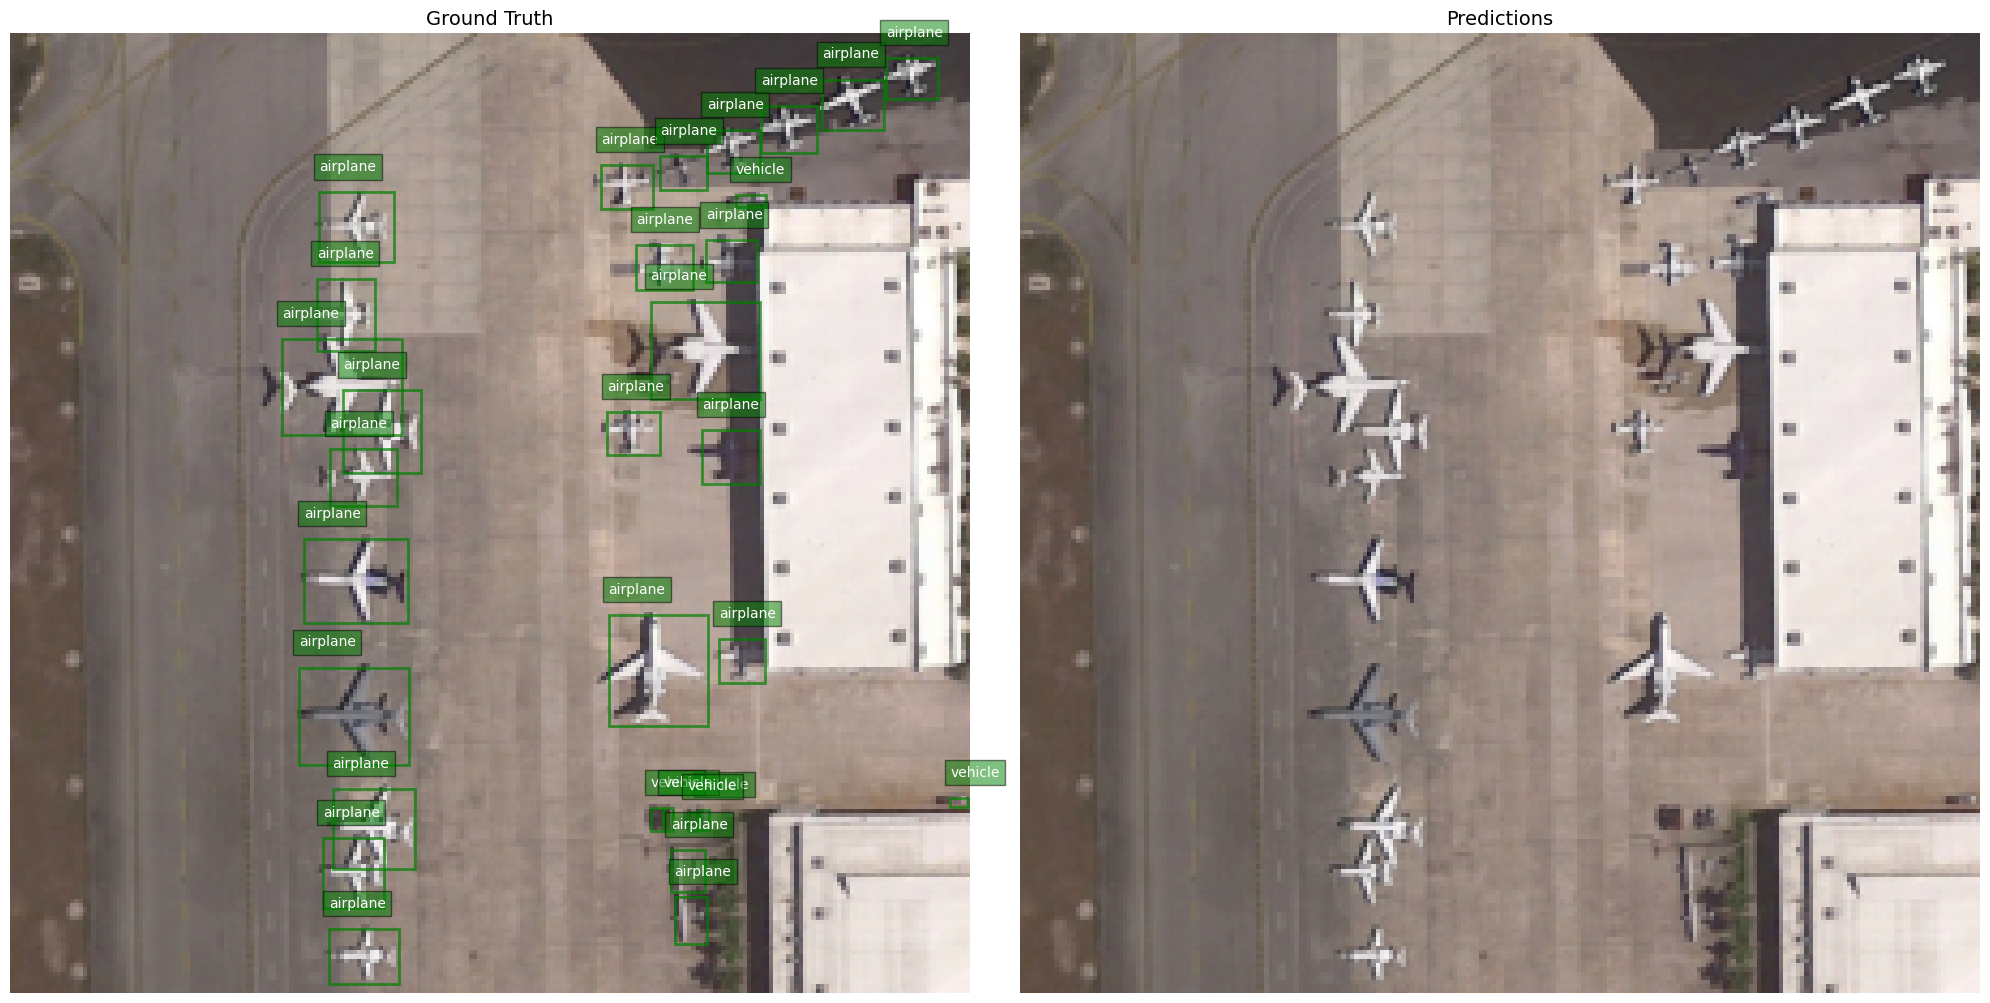

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
def run_visualization_from_test(model, test_loader, class_names, num_images=5, threshold=0.5):
    """
    Exécute le test et visualise les résultats pour un nombre spécifié d'images.

    Args:
        model: Le modèle à évaluer
        test_loader: DataLoader pour les données de test
        class_names: Liste des noms de classes
        num_images: Nombre d'images à visualiser
        threshold: Seuil de confiance pour les prédictions
    """
    model.eval()
    images_processed = 0

    with torch.no_grad():
        for images, targets in test_loader:
            if images_processed >= num_images:
                break

            # Préparer les entrées pour le modèle
            batch_images = torch.stack(images).to(device)
            batch_targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Obtenir les prédictions
            outputs = model(batch_images,batch_targets)

            # Traiter les prédictions
            pred_logits = outputs.logits  # [batch_size, num_queries, num_classes+1]
            pred_boxes = outputs.pred_boxes  # [batch_size, num_queries, 4]

            # Pour chaque image du batch
            for i in range(min(len(images), num_images - images_processed)):
                # Obtenir les prédictions pour cette image
                logits = pred_logits[i]  # [num_queries, num_classes+1]
                boxes = pred_boxes[i]    # [num_queries, 4]

                # Convertir en scores et labels
                probs = torch.softmax(logits, dim=-1)
                scores, labels = probs[:, :-1].max(dim=-1)  # Exclure la classe "no object"

                # Filtrer par seuil de confiance
                keep = scores > threshold
                filtered_boxes = boxes[keep].cpu().numpy()
                filtered_labels = labels[keep].cpu().numpy()
                filtered_scores = scores[keep].cpu().numpy()

                # Créer une figure avec deux sous-graphiques côte à côte
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

                # Obtenir l'image actuelle et la convertir en format PIL
                img = transforms.ToPILImage()(images[i].cpu()).convert("RGB")
                img_np = np.array(img)
                img_width, img_height = img.size

                # ---------- Image de gauche: vérité terrain ----------
                ax1.imshow(img_np)
                ax1.set_title("Ground Truth", fontsize=14)

                # Dessiner les boîtes vérité terrain
                for box, label_idx in zip(targets[i]['boxes'], targets[i]['class_labels']):
                    # Convertir les coordonnées normalisées en pixels
                    box_np = box.cpu().numpy()
                    x_min, y_min, x_max, y_max = box_np * np.array([img_width, img_height, img_width, img_height])
                    width = x_max - x_min
                    height = y_max - y_min

                    # Créer le rectangle
                    rect = Rectangle((x_min, y_min), width, height,
                                   linewidth=2, edgecolor='green',
                                   facecolor='none', alpha=0.7)
                    ax1.add_patch(rect)

                    # Ajouter le nom de classe
                    class_name = class_names[label_idx]
                    ax1.text(x_min, y_min - 5, f'{class_name}',
                            bbox=dict(facecolor='green', alpha=0.5),
                            fontsize=10, color='white')

                # ---------- Image de droite: prédictions ----------
                ax2.imshow(img_np)
                ax2.set_title("Predictions", fontsize=14)

                # Couleurs pour différentes classes
                colors = plt.cm.hsv(np.linspace(0, 1, len(class_names)))

                # Dessiner les boîtes prédites
                for box, label_idx, score in zip(filtered_boxes, filtered_labels, filtered_scores):
                    # Convertir les coordonnées normalisées en pixels
                    x_min, y_min, x_max, y_max = box * np.array([img_width, img_height, img_width, img_height])
                    width = x_max - x_min
                    height = y_max - y_min

                    # Créer le rectangle avec la couleur de la classe
                    rect = Rectangle((x_min, y_min), width, height,
                                   linewidth=2, edgecolor=colors[label_idx],
                                   facecolor='none', alpha=0.7)
                    ax2.add_patch(rect)

                    # Ajouter le nom de classe et le score
                    class_name = class_names[label_idx]
                    ax2.text(x_min, y_min - 5, f'{class_name}: {score:.2f}',
                            bbox=dict(facecolor=colors[label_idx], alpha=0.5),
                            fontsize=10, color='white')

                # Désactiver les axes et ajuster la mise en page
                ax1.axis('off')
                ax2.axis('off')
                plt.tight_layout()
                plt.show()

                images_processed += 1
                if images_processed >= num_images:
                    break


# Définir le seuil de confiance
threshold = 0.5

# Exécuter la visualisation directement
run_visualization_from_test(detr_with_dofa, test_loader,
                          train_dataset.classes,
                          num_images=1, threshold=threshold)

In [ ]:
def run_visualization_with_debug(model, test_loader, class_names, num_images=5, threshold=0.3):
    """
    Exécute le test et visualise les résultats avec des logs de débogage.

    Args:
        model: Le modèle à évaluer
        test_loader: DataLoader pour les données de test
        class_names: Liste des noms de classes
        num_images: Nombre d'images à visualiser
        threshold: Seuil de confiance pour les prédictions (réduit à 0.3 par défaut)
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    import numpy as np

    model.eval()
    images_processed = 0

    with torch.no_grad():
        for images, targets in test_loader:
            if images_processed >= num_images:
                break

            # Préparer les entrées pour le modèle
            batch_images = torch.stack(images).to(device)
            batch_targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Obtenir les prédictions
            # Note: utiliser le modèle sans les cibles pour l'inférence
            outputs = model(batch_images)

            # Débogage: afficher la structure des sorties
            print("\n===== STRUCTURE DES SORTIES =====")
            if hasattr(outputs, 'logits'):
                print(f"logits shape: {outputs.logits.shape}")
            else:
                print("Pas d'attribut 'logits' dans les sorties")
                # Essayer d'accéder à d'autres attributs possibles
                for attr_name in dir(outputs):
                    if not attr_name.startswith('_') and not callable(getattr(outputs, attr_name)):
                        try:
                            attr_value = getattr(outputs, attr_name)
                            if isinstance(attr_value, torch.Tensor):
                                print(f"{attr_name} shape: {attr_value.shape}")
                        except:
                            pass

            if hasattr(outputs, 'pred_boxes'):
                print(f"pred_boxes shape: {outputs.pred_boxes.shape}")
            else:
                print("Pas d'attribut 'pred_boxes' dans les sorties")

            # Pour chaque image du batch
            for i in range(min(len(images), num_images - images_processed)):
                # Obtenir l'image actuelle
                img = transforms.ToPILImage()(images[i].cpu()).convert("RGB")
                img_np = np.array(img)
                img_width, img_height = img.size

                # Créer une figure avec deux sous-graphiques côte à côte
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

                # ---------- Image de gauche: vérité terrain ----------
                ax1.imshow(img_np)
                ax1.set_title("Ground Truth", fontsize=14)

                # Afficher le nombre de boîtes vérité terrain
                print(f"\nImage {images_processed+1} - Nombre de boîtes vérité terrain: {len(targets[i]['boxes'])}")

                # Dessiner les boîtes vérité terrain
                for box, label_idx in zip(targets[i]['boxes'], targets[i]['class_labels']):
                    # Convertir les coordonnées normalisées en pixels
                    box_np = box.cpu().numpy()
                    x_min, y_min, x_max, y_max = box_np * np.array([img_width, img_height, img_width, img_height])
                    width = x_max - x_min
                    height = y_max - y_min

                    # Créer le rectangle
                    rect = Rectangle((x_min, y_min), width, height,
                                   linewidth=2, edgecolor='green',
                                   facecolor='none', alpha=0.7)
                    ax1.add_patch(rect)

                    # Ajouter le nom de classe
                    class_name = class_names[label_idx]
                    ax1.text(x_min, y_min - 5, f'{class_name}',
                            bbox=dict(facecolor='green', alpha=0.5),
                            fontsize=10, color='white')

                # Image de droite: prédictions 
                ax2.imshow(img_np)
                ax2.set_title("Predictions", fontsize=14)

                # Couleurs pour différentes classes
                colors = plt.cm.hsv(np.linspace(0, 1, len(class_names)))

                # Essayer d'extraire les prédictions avec différentes méthodes selon la structure des sorties
                if hasattr(outputs, 'logits') and hasattr(outputs, 'pred_boxes'):
                    # Structure standard pour DETR
                    logits = outputs.logits[i]  # [num_queries, num_classes+1]
                    boxes = outputs.pred_boxes[i]  # [num_queries, 4]

                    # Convertir en scores et labels
                    probs = torch.softmax(logits, dim=-1)
                    scores, labels = probs[:, :-1].max(dim=-1)  # Exclure la classe "no object"

                    # Débogage: afficher tous les scores
                    print(f"Scores avant seuil (top 5): {scores.topk(5)[0].cpu().numpy()}")

                    # Filtrer par seuil de confiance (plus bas pour le débogage)
                    keep = scores > threshold
                    filtered_boxes = boxes[keep].cpu().numpy()
                    filtered_labels = labels[keep].cpu().numpy()
                    filtered_scores = scores[keep].cpu().numpy()

                    print(f"Nombre de prédictions après filtrage (seuil={threshold}): {len(filtered_boxes)}")

                elif hasattr(outputs, 'pred_logits') and hasattr(outputs, 'pred_boxes'):
                    # Structure alternative possible
                    logits = outputs.pred_logits[i]
                    boxes = outputs.pred_boxes[i]

                    # Convertir en scores et labels
                    probs = torch.softmax(logits, dim=-1)
                    scores, labels = probs[:, :-1].max(dim=-1)

                    # Débogage: afficher tous les scores
                    print(f"Scores avant seuil (top 5): {scores.topk(5)[0].cpu().numpy()}")

                    # Filtrer par seuil de confiance (plus bas pour le débogage)
                    keep = scores > threshold
                    filtered_boxes = boxes[keep].cpu().numpy()
                    filtered_labels = labels[keep].cpu().numpy()
                    filtered_scores = scores[keep].cpu().numpy()

                    print(f"Nombre de prédictions après filtrage (seuil={threshold}): {len(filtered_boxes)}")
                else:
                    # Structure inconnue, essayons d'extraire les informations autrement
                    print("Structure de sortie non reconnue, essai d'extraction alternative...")
                    filtered_boxes = []
                    filtered_labels = []
                    filtered_scores = []

                    # Si les sorties sont un dictionnaire
                    if hasattr(outputs, '__getitem__'):
                        if 'pred_logits' in outputs and 'pred_boxes' in outputs:
                            logits = outputs['pred_logits'][i]
                            boxes = outputs['pred_boxes'][i]

                            probs = torch.softmax(logits, dim=-1)
                            scores, labels = probs[:, :-1].max(dim=-1)

                            keep = scores > threshold
                            filtered_boxes = boxes[keep].cpu().numpy()
                            filtered_labels = labels[keep].cpu().numpy()
                            filtered_scores = scores[keep].cpu().numpy()

                # Dessiner les boîtes prédites
                print(f"Dessin de {len(filtered_boxes)} boîtes prédites")
                for j, (box, label_idx, score) in enumerate(zip(filtered_boxes, filtered_labels, filtered_scores)):
                    # Débogage: afficher les coordonnées des boîtes
                    print(f"Boîte {j+1}: {box}, Label: {label_idx}, Score: {score:.4f}")

                    # Convertir les coordonnées normalisées en pixels
                    x_min, y_min, x_max, y_max = box * np.array([img_width, img_height, img_width, img_height])

                    # Vérifier si les coordonnées sont valides
                    if x_min < 0 or y_min < 0 or x_max > img_width or y_max > img_height:
                        print(f" Coordonnées hors limites: [{x_min}, {y_min}, {x_max}, {y_max}]")
                        # Corriger les coordonnées si nécessaire
                        x_min = max(0, x_min)
                        y_min = max(0, y_min)
                        x_max = min(img_width, x_max)
                        y_max = min(img_height, y_max)

                    width = x_max - x_min
                    height = y_max - y_min

                    # Vérifier si la boîte a une surface positive
                    if width <= 0 or height <= 0:
                        print(f" Dimensions invalides: largeur={width}, hauteur={height}")
                        continue

                    # Créer le rectangle avec la couleur de la classe
                    rect = Rectangle((x_min, y_min), width, height,
                                   linewidth=2, edgecolor=colors[label_idx % len(colors)],
                                   facecolor='none', alpha=0.7)
                    ax2.add_patch(rect)

                    # Ajouter le nom de classe et le score
                    if 0 <= label_idx < len(class_names):
                        class_name = class_names[label_idx]
                    else:
                        class_name = f"Unknown-{label_idx}"
                        print(f" Label index hors limites: {label_idx}, max={len(class_names)-1}")

                    ax2.text(x_min, y_min - 5, f'{class_name}: {score:.2f}',
                            bbox=dict(facecolor=colors[label_idx % len(colors)], alpha=0.5),
                            fontsize=10, color='white')

                # Si aucune boîte n'a été dessinée, afficher un message
                if len(filtered_boxes) == 0:
                    ax2.text(img_width/2, img_height/2, "Aucune prédiction (score > threshold)",
                            ha='center', va='center', fontsize=14, color='red',
                            bbox=dict(facecolor='white', alpha=0.7))

                # Désactiver les axes et ajuster la mise en page
                ax1.axis('off')
                ax2.axis('off')
                plt.tight_layout()
                plt.show()

                images_processed += 1
                if images_processed >= num_images:
                    break

# Définir le seuil de confiance
threshold = 0.1

# Exécuter la visualisation directement
run_visualization_from_test(detr_with_dofa, test_loader,
                          train_dataset.classes,
                          num_images=100, threshold=threshold)